# Importing the Libraries & Loading the Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.neural_network import MLPClassifier
from difflib import get_close_matches
import warnings
warnings.filterwarnings('ignore')

In [2]:
symptoms_df = pd.read_csv('symtoms_df.csv')
description_df = pd.read_csv('description.csv')
precautions_df = pd.read_csv('precautions_df.csv')
medications_df = pd.read_csv('medications.csv')
diets_df = pd.read_csv('diets.csv')

# Cleaning Data

In [3]:
for df in [symptoms_df, description_df, precautions_df, medications_df, diets_df]:
    for col in df.columns:
        if df[col].dtype == 'object':
            df[col] = df[col].str.strip()

In [4]:
symptom_cols = ['Symptom_1', 'Symptom_2', 'Symptom_3', 'Symptom_4']
unique_symptoms = []
for col in symptom_cols:
    unique_symptoms.extend(symptoms_df[col].dropna().unique().tolist())
unique_symptoms = sorted(list(set([s.strip() for s in unique_symptoms])))

print(f"Total unique symptoms: {len(unique_symptoms)}")
print(f"Total diseases: {len(symptoms_df['Disease'].unique())}")

Total unique symptoms: 86
Total diseases: 41


# Training Multiple Models

In [5]:
X = pd.DataFrame(0, index=np.arange(len(symptoms_df)), columns=unique_symptoms)
for i, row in symptoms_df.iterrows():
    for col in symptom_cols:
        val = row[col]
        if pd.notna(val):
            X.at[i, val.strip()] = 1

# Encode target variable
le = LabelEncoder()
y_encoded = le.fit_transform(symptoms_df['Disease'])

# Train-test split for evaluation
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Train multiple models
print("\nTraining models...")
models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'SVM': SVC(kernel='rbf', probability=True, random_state=42),
    'Naive Bayes': MultinomialNB(),
    'Neural Network': MLPClassifier(hidden_layer_sizes=(128, 64), max_iter=500, random_state=42)
}

trained_models = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    trained_models[name] = {'model': model, 'accuracy': accuracy}
    print(f"{name} Accuracy: {accuracy*100:.2f}%")

# Use the best model (Random Forest by default, but can be changed)
rf_model = trained_models['Random Forest']['model']
rf_model.fit(X, y_encoded)  # Retrain on full dataset


Training models...
Random Forest Accuracy: 99.49%
SVM Accuracy: 99.49%
Naive Bayes Accuracy: 99.49%
Neural Network Accuracy: 99.49%


RandomForestClassifier(random_state=42)

# Extracting Symptoms

In [6]:
def extract_symptoms(user_input):
    """Extract symptoms from user input using phrase matching and fuzzy matching"""
    user_input = user_input.lower().strip()
    
    # Slang/synonym mapping
    synonyms = {
        "itchy": "itching",
        "thorny": "patches_in_throat",
        "runny nose": "continuous_sneezing",
        "throwing up": "vomiting",
        "puke": "vomiting",
        "sick": "nausea",
        "dizzy": "dizziness",
        "tired": "fatigue",
        "hot": "high_fever",
        "cold": "chills",
        "cough": "cough",
        "headache": "headache",
        "stomach ache": "stomach_pain",
        "belly pain": "stomach_pain"
    }
    
    for slang, formal in synonyms.items():
        user_input = user_input.replace(slang, formal)
    
    found = []
    
    # 1. Exact phrase search (higher priority)
    for s in unique_symptoms:
        symptom_phrase = s.replace('_', ' ').strip()
        if symptom_phrase in user_input:
            found.append(s)
    
    # 2. Fuzzy matching for typos
    words = user_input.split()
    for word in words:
        if len(word) > 3:  # Only match words longer than 3 characters
            symptom_words = [s.replace('_', ' ') for s in unique_symptoms]
            matches = get_close_matches(word, symptom_words, n=1, cutoff=0.85)
            if matches:
                matched_symptom = matches[0].replace(' ', '_')
                if matched_symptom not in found:
                    found.append(matched_symptom)
    
    return list(set(found))

# Displating Report and Getting Predections

In [7]:
def get_top_predictions(input_vector, top_n=3):
    """Get top N disease predictions with probabilities"""
    probs = rf_model.predict_proba([input_vector])[0]
    top_indices = np.argsort(probs)[-top_n:][::-1]
    
    results = []
    for idx in top_indices:
        disease = le.inverse_transform([idx])[0]
        confidence = probs[idx]
        results.append((disease, confidence))
    
    return results

def display_final_report(disease, confidence, symptoms_list, show_alternatives=True):
    """Display comprehensive diagnosis report"""
    try:
        desc = description_df[description_df['Disease'] == disease]['Description'].values[0]
    except:
        desc = "No description available."
    
    try:
        med = medications_df[medications_df['Disease'] == disease]['Medication'].values[0]
    except:
        med = "Please consult a doctor."
    
    try:
        diet = diets_df[diets_df['Disease'] == disease]['Diet'].values[0]
    except:
        diet = "Follow a balanced diet."
    
    try:
        pre = precautions_df[precautions_df['Disease'] == disease].iloc[0]
    except:
        pre = None
    
    print("\n" + "="*60)
    print(f"DIAGNOSIS REPORT: {disease}")
    print(f"Confidence: {confidence*100:.1f}%")
    print("="*60)
    print(f"\nSymptoms Detected: {', '.join([s.replace('_', ' ') for s in symptoms_list])}")
    print(f"\nDescription:\n{desc}")
    print(f"\nRecommended Medication:\n{med}")
    print(f"\nDietary Recommendations:\n{diet}")
    
    if pre is not None:
        print("\nPrecautions:")
        for i in range(1, 5):
            p = pre[f'Precaution_{i}']
            if pd.notna(p) and str(p) != 'nan':
                print(f"  • {p}")
    
    # Show alternative diagnoses
    if show_alternatives:
        input_vector = np.zeros(len(unique_symptoms))
        for s in symptoms_list:
            if s in unique_symptoms:
                input_vector[unique_symptoms.index(s)] = 1
        
        top_3 = get_top_predictions(input_vector, top_n=3)
        if len(top_3) > 1:
            print("\nAlternative Diagnoses:")
            for alt_disease, alt_conf in top_3[1:]:
                print(f"  • {alt_disease} ({alt_conf*100:.1f}%)")
    
    print("\n⚠️  DISCLAIMER: This is an AI-based prediction tool.")
    print("   Please consult a qualified healthcare professional for")
    print("   accurate diagnosis and treatment.")
    print("="*60 + "\n")

# Chatbot Logic

In [8]:
def start_diagnostic_session():
    """Interactive diagnostic session with smart symptom probing"""
    session_symptoms = []
    rejected_symptoms = []
    
    print("\n" + "="*60)
    print("        AI MEDICAL DIAGNOSTIC ASSISTANT")
    print("="*60)
    print("\nWelcome! I'll help you identify potential health conditions")
    print("based on your symptoms.")
    print("\nInstructions:")
    print("  • Describe your symptoms naturally")
    print("  • Answer follow-up questions with 'yes' or 'no'")
    print("  • Type 'exit' to quit anytime")
    print("  • Type 'restart' to begin a new session")
    print("="*60 + "\n")
    
    user_msg = input("How are you feeling? Describe your symptoms: ")
    
    while True:
        if user_msg.lower() in ['exit', 'quit']:
            print("\nThank you for using the diagnostic assistant. Stay healthy!")
            break
        
        if user_msg.lower() == 'restart':
            session_symptoms = []
            rejected_symptoms = []
            user_msg = input("\nStarting new session. Describe your symptoms: ")
            continue
        
        # Extract symptoms from user input
        new_symptoms = extract_symptoms(user_msg)
        for s in new_symptoms:
            if s not in session_symptoms:
                session_symptoms.append(s)
        
        if not session_symptoms:
            user_msg = input("\nI couldn't identify any symptoms. Could you describe them differently?\n> ")
            continue
        
        # Create input vector from accumulated symptoms
        input_vector = np.zeros(len(unique_symptoms))
        for s in session_symptoms:
            if s in unique_symptoms:
                input_vector[unique_symptoms.index(s)] = 1
        
        # Get prediction
        probs = rf_model.predict_proba([input_vector])[0]
        confidence = np.max(probs)
        predicted_disease = le.inverse_transform([np.argmax(probs)])[0]
        
        # Decision logic
        if confidence > 0.75 or len(session_symptoms) >= 5:
            # High confidence or enough symptoms - provide diagnosis
            display_final_report(predicted_disease, confidence, session_symptoms)
            
            # Ask if user wants to start a new session
            again = input("Would you like to start a new diagnosis? (yes/no): ")
            if again.lower() in ['yes', 'y']:
                session_symptoms = []
                rejected_symptoms = []
                user_msg = input("\nStarting new session. Describe your symptoms: ")
            else:
                print("\nThank you for using the diagnostic assistant. Stay healthy!")
                break
        else:
            # Ask probing questions
            disease_row = symptoms_df[symptoms_df['Disease'] == predicted_disease].iloc[0]
            potentials = [disease_row[c] for c in symptom_cols if pd.notna(disease_row[c])]
            
            suggestions = [s.strip() for s in potentials 
                          if s.strip() not in session_symptoms 
                          and s.strip() not in rejected_symptoms]
            
            if suggestions:
                next_q = suggestions[0].replace('_', ' ')
                print(f"\nCurrent symptoms: {', '.join([s.replace('_', ' ') for s in session_symptoms])}")
                ans = input(f"Do you also experience {next_q}? (yes/no): ").lower()
                
                if 'yes' in ans or 'y' == ans:
                    session_symptoms.append(suggestions[0])
                    user_msg = ""  # Re-evaluate with new symptom
                else:
                    rejected_symptoms.append(suggestions[0])
                    user_msg = ""  # Re-evaluate without this symptom
            else:
                # No more suggestions available
                ans = input("\nAny other symptoms you'd like to mention? (or type 'done' to see diagnosis): ").lower()
                if ans in ['done', 'no', 'nope', 'n', '']:
                    # Force diagnosis with current symptoms
                    display_final_report(predicted_disease, confidence, session_symptoms)
                    
                    again = input("\nWould you like to start a new diagnosis? (yes/no): ")
                    if again.lower() in ['yes', 'y']:
                        session_symptoms = []
                        rejected_symptoms = []
                        user_msg = input("\nStarting new session. Describe your symptoms: ")
                    else:
                        print("\nThank you for using the diagnostic assistant. Stay healthy!")
                        break
                else:
                    user_msg = ans  # Process the new symptoms

# Model Comaprision


Options:
1. Start Diagnostic Session
2. View Model Performance
3. Exit



Enter your choice (1-3):  2



Model comparison plot saved as 'model_comparison.png'


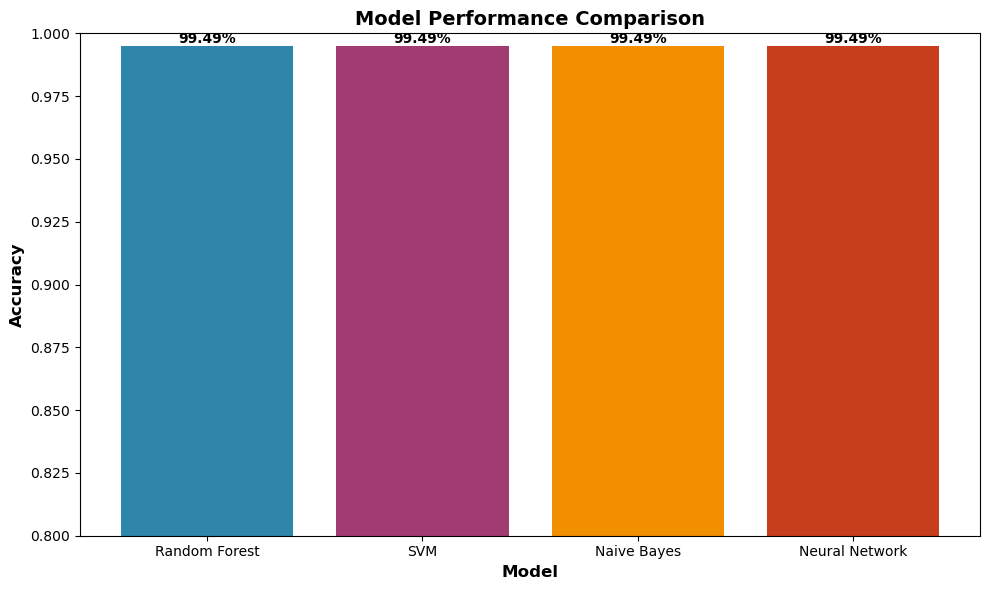


Would you like to start a diagnostic session? (yes/no):  yes



        AI MEDICAL DIAGNOSTIC ASSISTANT

Welcome! I'll help you identify potential health conditions
based on your symptoms.

Instructions:
  • Describe your symptoms naturally
  • Answer follow-up questions with 'yes' or 'no'
  • Type 'exit' to quit anytime
  • Type 'restart' to begin a new session



How are you feeling? Describe your symptoms:  I am feeling pain in my knees

I couldn't identify any symptoms. Could you describe them differently?
>  knee pain



Current symptoms: knee pain


Do you also experience joint pain? (yes/no):  yes



Current symptoms: knee pain, joint pain


Do you also experience neck pain? (yes/no):  no



Current symptoms: knee pain, joint pain


Do you also experience hip joint pain? (yes/no):  no

Any other symptoms you'd like to mention? (or type 'done' to see diagnosis):  Difficulty in moving

Any other symptoms you'd like to mention? (or type 'done' to see diagnosis):  no



DIAGNOSIS REPORT: Osteoarthristis
Confidence: 53.0%

Symptoms Detected: knee pain, joint pain

Description:
Osteoarthristis is a degenerative joint disease that affects the cartilage in joints.

Recommended Medication:
['NSAIDs', 'Disease-modifying antirheumatic drugs (DMARDs)', 'Biologics', 'Corticosteroids', 'Joint replacement surgery']

Dietary Recommendations:
['Arthritis Diet', 'Anti-Inflammatory Diet', 'Omega-3-rich foods', 'Fruits and vegetables', 'Whole grains']

Precautions:
  • acetaminophen
  • consult nearest hospital
  • follow up
  • salt baths

Alternative Diagnoses:
  • Psoriasis (9.0%)
  • hepatitis A (8.9%)

⚠️  DISCLAIMER: This is an AI-based prediction tool.
   Please consult a qualified healthcare professional for
   accurate diagnosis and treatment.




Would you like to start a new diagnosis? (yes/no):  no



Thank you for using the diagnostic assistant. Stay healthy!


In [10]:
def plot_model_comparison():
    """Visualize model performance comparison"""
    model_names = list(trained_models.keys())
    accuracies = [trained_models[name]['accuracy'] for name in model_names]
    
    plt.figure(figsize=(10, 6))
    bars = plt.bar(model_names, accuracies, color=['#2E86AB', '#A23B72', '#F18F01', '#C73E1D'])
    plt.xlabel('Model', fontsize=12, fontweight='bold')
    plt.ylabel('Accuracy', fontsize=12, fontweight='bold')
    plt.title('Model Performance Comparison', fontsize=14, fontweight='bold')
    plt.ylim(0.8, 1.0)
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height*100:.2f}%',
                ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.savefig('model_comparison.png', dpi=300)
    print("\nModel comparison plot saved as 'model_comparison.png'")
    plt.show()

# Main execution
if __name__ == "__main__":
    print("\n" + "="*60)
    print("Options:")
    print("1. Start Diagnostic Session")
    print("2. View Model Performance")
    print("3. Exit")
    print("="*60)
    
    choice = input("\nEnter your choice (1-3): ")
    
    if choice == '1':
        start_diagnostic_session()
    elif choice == '2':
        plot_model_comparison()
        cont = input("\nWould you like to start a diagnostic session? (yes/no): ")
        if cont.lower() in ['yes', 'y']:
            start_diagnostic_session()
    else:
        print("\nGoodbye!")